Sử dụng mô hình LTSM trong việc tạo Image caption.


Ứng dụng:

• Để giúp những người già mắt kém hoặc người mù có thể biết được cảnh vật xung quanh hay hỗ trợ việc di chuyển. Quy trình sẽ là: Image -> text -> voice.

• Giúp google search có thể tìm kiếm được hình ảnh dựa vào caption.

Dataset: https://academictorrents.com/details/9dea07ba660a722ae1008c4c8afdd303b6f6e53b

Dữ liệu gồm 8000 ảnh, 6000
ảnh cho training set, 1000 cho dev set (validation set) và 1000 ảnh cho test set

Một ảnh 5 caption sẽ cho ra 5 training set khác nhau: (ảnh, caption 1), (ảnh, caption 2), (ảnh,
caption 3), (ảnh, caption 4), (ảnh, caption 5). Như vậy training set sẽ có 6000 * 5 = 30000 dataset.


In [41]:
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
# %matplotlib inline
import string
import os
import re
from PIL import Image
import glob
from pickle import dump, load
from time import time
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
Activation, Flatten, Reshape, concatenate, \
Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers import Bidirectional
from keras.layers import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

In [5]:
# Read the caption file
def load_doc(filename):
  # open the file as read only
  file = open(filename, 'r')
  # read all text
  text = file.read()
  # close the file
  file.close()
  return text
filename = "/content/drive/MyDrive/Flickr8k/Flickr8k_text/Flickr8k.token.txt"
doc = load_doc(filename)
print(doc[:300])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the s


In [6]:
# Save captions in key-values:
#id_image : ['caption 1', 'caption 2', 'caption 3',' caption 4', 'caption 5']
def load_descriptions(doc):
  mapping = dict()
  # process lines
  for line in doc.split('\n'):
    # split line by white space
    tokens = line.split()
    if len(line) < 2:
      continue
    # take the first token as the image id, the rest as the description
    image_id, image_desc = tokens[0], tokens[1:]
    # extract filename from image id
    image_id = image_id.split('.')[0]
    # convert description tokens back to string
    image_desc = ' '.join(image_desc)
    # create the list if needed
    if image_id not in mapping:
      mapping[image_id] = list()
    # store description
    mapping[image_id].append(image_desc)
  return mapping

descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))

descriptions['1000268201_693b08cb0e']

Loaded: 8092 


['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [7]:
# Preprocessing text
def clean_descriptions(descriptions):
  # prepare translation table for removing punctuation
  table = str.maketrans('', '', string.punctuation)
  for key, desc_list in descriptions.items():
      for i in range(len(desc_list)):
        desc = desc_list[i]
        # tokenize
        desc = desc.split()
        # convert to lower case
        desc = [word.lower() for word in desc]
        # remove punctuation from each token
        desc = [w.translate(table) for w in desc]
        # remove hanging 's' and 'a'
        desc = [word for word in desc if len(word)>1]
        # remove tokens with numbers in them
        desc = [word for word in desc if word.isalpha()]
        # store as string
        desc_list[i] = ' '.join(desc)

# clean descriptions
clean_descriptions(descriptions)
descriptions['1000268201_693b08cb0e']

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [9]:
# Save descriptions into file
def save_descriptions(descriptions, filename):
  lines = list()
  for key, desc_list in descriptions.items():
    for desc in desc_list:
      lines.append(key + ' ' + desc)
  data = '\n'.join(lines)
  file = open(filename, 'w')
  file.write(data)
  file.close()
save_descriptions(descriptions, '/content/drive/MyDrive/Flickr8k/descriptions.txt')

In [10]:
# get the id corresponding to train, test, dev
def load_set(filename):
  doc = load_doc(filename)
  dataset = list()
  # process line by line
  for line in doc.split('\n'):
    # skip empty lines
    if len(line) < 1:
      continue
  # get the image identifier
    identifier = line.split('.')[0]
    dataset.append(identifier)
  return set(dataset)

In [11]:
# load training dataset (6K)
filename = '/content/drive/MyDrive/Flickr8k/Flickr8k_text/Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))

Dataset: 6000


In [12]:
# Folder have the images
images = '/content/drive/MyDrive/Flickr8k/Flicker8k_Dataset/'
# Lấy lấy các ảnh jpg trong thư mục
img = glob.glob(images + '*.jpg')

In [13]:
# File chứa các id ảnh để train
train_images_file = '/content/drive/MyDrive/Flickr8k/Flickr8k_text/Flickr_8k.trainImages.txt'
# Read the train image names in a set
train_images = set(open(train_images_file, 'r').read().strip().split('\n'))

In [14]:
# Create a list of all the training images with their full path names
train_img = []
for i in img: # img is list of full path names of all images
    if i[len(images):] in train_images: # Check if the image belongs to training set
      train_img.append(i) # Add it to the list of train images

In [15]:
# File chứa các id ảnh để test
test_images_file = '/content/drive/MyDrive/Flickr8k/Flickr8k_text/Flickr_8k.testImages.txt'
# Read the validation image names in a set# Read the test image names in a set
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))

In [16]:
# Create a list of all the test images with their full path names
test_img = []
for i in img: # img is list of full path names of all images
  if i[len(images):] in test_images: # Check if the image belongs to test set
    test_img.append(i) # Add it to the list of test images

In [17]:
# Thêm 'startseq', 'endseq' cho chuỗi
def load_clean_descriptions(filename, dataset):
  # load document
  doc = load_doc(filename)
  descriptions = dict()
  for line in doc.split('\n'):
      # split line by white space
      tokens = line.split()
      # split id from description
      image_id, image_desc = tokens[0], tokens[1:]
      # skip images not in the set
      if image_id in dataset:
        # create list
        if image_id not in descriptions:
          descriptions[image_id] = list()
        # wrap description in tokens
        desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
        # store
        descriptions[image_id].append(desc)
  return descriptions

In [18]:
# descriptions
train_descriptions = load_clean_descriptions('/content/drive/MyDrive/Flickr8k/descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))

Descriptions: train=6000


In [19]:
# Load ảnh, resize về khích thước mà Inception v3 yêu cầu.
def preprocess(image_path):
    # Convert all the images to size 299x299 as expected by the inception v3 model
    img = image.load_img(image_path, target_size=(299, 299))
    # Convert PIL image to numpy array of 3-dimensions
    x = image.img_to_array(img)
    # Add one more dimension
    x = np.expand_dims(x, axis=0)
    # preprocess the images using preprocess_input() from inception module
    x = preprocess_input(x)
    return x

In [20]:
# Load the inception v3 model
model = InceptionV3(weights='imagenet')
# Tạo model mới, bỏ layer cuối từ inception v3
model_new = Model(model.input, model.layers[-2].output)

96112376/96112376 [==============================] - 1s 0us/step


In [21]:
# Image embedding thành vector (2048, )
def encode(image):
  image = preprocess(image) # preprocess the image
  fea_vec = model_new.predict(image) # Get the encoding vector for the image
  fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
  return fea_vec

In [22]:
# Gọi hàm encode với các ảnh trong training set
start = time()
encoding_train = {}
for img in train_img:
  encoding_train[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
1/1 [==============================] - 0s 241ms/step
Time taken in seconds = 3012.565806388855


In [24]:
# Lưu image embedding lại
with open("/content/drive/MyDrive/Flickr8k/Pickle/encoded_train_images.pkl", "wb") as encoded_pickle:
  dump(encoding_train, encoded_pickle)

In [25]:
# Encode test image
start = time()
encoding_test = {}
for img in test_img:
  encoding_test[img[len(images):]] = encode(img)

print("Time taken in seconds =", time()-start)

1/1 [==============================] - 0s 442ms/step
Time taken in seconds = 431.50091767311096


In [27]:
# Save the bottleneck test features to disk
with open("/content/drive/MyDrive/Flickr8k/Pickle/encoded_test_images.pkl", "wb") as encoded_pickle:
  dump(encoding_test, encoded_pickle)

In [28]:
train_features = load(open("/content/drive/MyDrive/Flickr8k/Pickle/encoded_train_images.pkl", "rb"))
print('Photos: train=%d' % len(train_features))

Photos: train=6000


In [29]:
# Tạo list các training caption
all_train_captions = []
for key, val in train_descriptions.items():
  for cap in val:
    all_train_captions.append(cap)
len(all_train_captions)

30000

In [30]:
# Chỉ lấy các từ xuất hiện trên 10 lần
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
  nsents += 1
  for w in sent.split(' '):
    word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))

ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
  wordtoix[w] = ix
  ixtoword[ix] = w
  ix += 1

vocab_size = len(ixtoword) + 1 # Thêm 1 cho từ dùng để padding
vocab_size

preprocessed words 7578 -> 1651


1652

In [31]:
# convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
  all_desc = list()
  for key in descriptions.keys():
    [all_desc.append(d) for d in descriptions[key]]
  return all_desc

In [32]:
# calculate the length of the description with the most words
def max_length(descriptions):
  lines = to_lines(descriptions)
  return max(len(d.split()) for d in lines)

# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

Description Length: 34


In [33]:
# data generator cho việc train theo từng batch model.fit_generator()
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
  X1, X2, y = list(), list(), list()
  n=0
  # loop for ever over images
  while 1:
    for key, desc_list in descriptions.items():
      n+=1
      # retrieve the photo feature
      photo = photos[key+'.jpg']
      for desc in desc_list:
        # encode the sequence
        seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
        # split one sequence into multiple X, y pairs
        for i in range(1, len(seq)):
          # split into input and output pair
          in_seq, out_seq = seq[:i], seq[i]
          # pad input sequence
          in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
          # encode output sequence
          out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
          # store
          X1.append(photo)
          X2.append(in_seq)
          y.append(out_seq)
      # yield the batch data
      if n==num_photos_per_batch:
        yield [[array(X1), array(X2)], array(y)]
        X1, X2, y = list(), list(), list()
        n=0

In [49]:
def print_first_20_lines(file_path):
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            # Đọc 20 dòng đầu tiên
            for i in range(20):
                line = file.readline()
                if line:  # Kiểm tra nếu dòng không rỗng
                    print(line.strip())  # Loại bỏ ký tự xuống dòng khi in
                else:
                    break  # Dừng lại nếu gặp cuối tệp
    except Exception as e:
        print(f"An error occurred: {e}")

# Đường dẫn tới tệp
file_path = '/content/drive/MyDrive/Flickr8k/glove.6B.200d/glove.6B.200d.txt'

# Gọi hàm để in 20 dòng đầu tiên
print_first_20_lines(file_path)

the -0.071549 0.093459 0.023738 -0.090339 0.056123 0.32547 -0.39796 -0.092139 0.061181 -0.1895 0.13061 0.14349 0.011479 0.38158 0.5403 -0.14088 0.24315 0.23036 -0.55339 0.048154 0.45662 3.2338 0.020199 0.049019 -0.014132 0.076017 -0.11527 0.2006 -0.077657 0.24328 0.16368 -0.34118 -0.06607 0.10152 0.038232 -0.17668 -0.88153 -0.33895 -0.035481 -0.55095 -0.016899 -0.43982 0.039004 0.40447 -0.2588 0.64594 0.26641 0.28009 -0.024625 0.63302 -0.317 0.10271 0.30886 0.097792 -0.38227 0.086552 0.047075 0.23511 -0.32127 -0.28538 0.1667 -0.0049707 -0.62714 -0.24904 0.29713 0.14379 -0.12325 -0.058178 -0.001029 -0.082126 0.36935 -0.00058442 0.34286 0.28426 -0.068599 0.65747 -0.029087 0.16184 0.073672 -0.30343 0.095733 -0.5286 -0.22898 0.064079 0.015218 0.34921 -0.4396 -0.43983 0.77515 -0.87767 -0.087504 0.39598 0.62362 -0.26211 -0.30539 -0.022964 0.30567 0.06766 0.15383 -0.11211 -0.09154 0.082562 0.16897 -0.032952 -0.28775 -0.2232 -0.090426 1.2407 -0.18244 -0.0075219 -0.041388 -0.011083 0.078186 0.3

In [48]:
# Load Glove model
glove_dir = ''
embeddings_index = {} # empty dictionary
f = open(os.path.join(glove_dir, '/content/drive/MyDrive/Flickr8k/glove.6B.200d/glove.6B.200d.txt'), encoding="utf-8")

for line in f:
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

embeddings_index['the']

embedding_dim = 200

# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoix.items():
#if i < max_words:
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    # Words not found in the embedding index will be all zeros
    embedding_matrix[i] = embedding_vector
embedding_matrix.shape

Found 400000 word vectors.


(1652, 200)

In [50]:
# Tạo model
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 34)]                 0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 2048)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, 34, 200)              330400    ['input_3[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 2048)                 0         ['input_2[0][0]']             
                                                                                            

In [51]:
# Layer 2 dùng GLOVE Model nên set weight thẳng và không cần train
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.optimizer.lr = 0.0001
epochs = 10
number_pics_per_bath = 6
steps = len(train_descriptions)//number_pics_per_bath
for i in range(epochs):
  generator = data_generator (train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
  model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)

model.save_weights('/content/drive/MyDrive/Flickr8k/model_weights/model_30.h5')

images = '/content/drive/MyDrive/Flickr8k/Flicker8k_Dataset/'
with open("/content/drive/MyDrive/Flickr8k/Pickle/encoded_test_images.pkl", "rb") as encoded_pickle:
  encoding_test = load(encoded_pickle)


<ipython-input-51-89a987dff990>:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)


1000/1000 [==============================] - 743s 742ms/step - loss: 3.3845


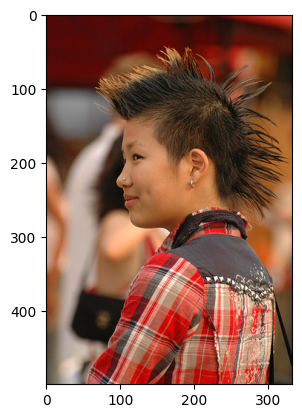

woman in red shirt is standing in front of the camera


In [67]:
# Với mỗi ảnh mới khi test, ta sẽ bắt đầu chuỗi với 'startseq' rồi
# sau đó cho vào model để dự đoán từ tiếp theo.
# Ta thêm từ vừa được dự đoán vào chuỗi và tiếp tục cho đến khi gặp 'endseq'
# là kết thúc hoặc cho đến khi chuỗi dài 34 từ.

def greedySearch(photo):
  in_text = 'startseq'
  for i in range(max_length):
      sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
      sequence = pad_sequences([sequence], maxlen=max_length)
      yhat = model.predict([photo,sequence], verbose=0)
      yhat = np.argmax(yhat)
      word = ixtoword[yhat]
      in_text += ' ' + word
      if word == 'endseq':
        break
  final = in_text.split()
  final = final[1:-1]
  final = ' '.join(final)
  return final

z=124
pic = list(encoding_test.keys())[z]
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print(greedySearch(image))